In [1]:
from hype.graph import eval_reconstruction, load_adjacency_matrix, load_edge_list
import numpy as np
import torch
import os
from hype.lorentz import LorentzManifold
from hype.euclidean import EuclideanManifold, TranseManifold
from hype.poincare import PoincareManifold
import timeit
import argparse
from argparse import Namespace

In [2]:
MANIFOLDS = {
    'lorentz': LorentzManifold,
    'euclidean': EuclideanManifold,
    'transe': TranseManifold,
    'poincare': PoincareManifold
}

In [3]:
np.random.seed(42)

In [4]:
idx, objects, weights = load_edge_list("wordnet/mammal_closure.csv")

In [5]:
len(idx), len(objects), len(weights)

(6540, 1180, 6540)

In [6]:
namedEdges = []
for row in idx:
    namedEdges.append(objects[row[0]])

In [7]:
[(objects[row[0]], objects[row[1]]) for i, row in enumerate(idx) if 'rodent.n.01' == objects[row[0]]]

[('rodent.n.01', 'mammal.n.01'), ('rodent.n.01', 'placental.n.01')]

In [8]:
mammals_opt = Namespace(batchsize=10, 
                        burnin=20, 
                        burnin_multiplier=0.01, 
                        checkpoint='mammals_euclidean_TEST.pth', 
                        dampening=0.75, 
                        debug=False, 
                        dim=20, 
                        dset='wordnet/mammal_closure.csv', 
                        epochs=300, 
                        eval_each=1, 
                        fresh=True, 
                        gpu=-1, 
                        lr=0.3, 
                        lr_type='constant', 
                        manifold='euclidean', 
                        maxnorm=500000, 
                        ndproc=1, 
                        neg_multiplier=1.0, 
                        negs=50, 
                        quiet=False, 
                        sparse=True, 
                        sym=False, 
                        train_threads=1)
opt = mammals_opt

### Simulate embed.py

In [9]:
import torch as th
import numpy as np
import logging
import argparse
from hype.sn import Embedding, initialize
from hype.adjacency_matrix_dataset import AdjacencyDataset
from hype import train
from hype.graph import load_adjacency_matrix, load_edge_list, eval_reconstruction
from hype.checkpoint import LocalCheckpoint
from hype.rsgd import RiemannianSGD
from hype.lorentz import LorentzManifold
from hype.euclidean import EuclideanManifold
from hype.poincare import PoincareManifold
import sys
import json
import torch.multiprocessing as mp
import shutil

In [10]:
th.manual_seed(42)
np.random.seed(42)

In [11]:
log_level = logging.DEBUG if opt.debug else logging.INFO

In [12]:
log_level, logging.DEBUG

(20, 10)

In [13]:
th.set_default_tensor_type('torch.DoubleTensor')
# set device
device = th.device(f'cuda:{opt.gpu}' if opt.gpu >= 0 else 'cpu')

In [14]:
device

device(type='cpu')

In [15]:
opt.manifold, opt.maxnorm

('euclidean', 500000)

In [16]:
manifold = MANIFOLDS[opt.manifold](debug=opt.debug, max_norm=opt.maxnorm)

In [17]:
opt.dim

20

In [18]:
manifold.dim(opt.dim)

20

In [19]:
idx, objects, weights = load_edge_list(opt.dset, opt.sym)

In [20]:
opt.sparse

True

In [21]:
model_name = '%s_dim%d'
mname = model_name % (opt.manifold, opt.dim)

In [22]:
mname

'euclidean_dim20'

In [23]:
from hype.graph_dataset import BatchedDataset

In [24]:
data = BatchedDataset(idx, objects, weights, opt.negs, opt.batchsize, opt.ndproc, opt.burnin > 0, opt.dampening)

In [25]:
len(data), len(idx), len(data.objects)

(654, 6540, 1180)

In [26]:
opt.ndproc, opt.dampening, opt.burnin, opt.batchsize

(1, 0.75, 20, 10)

In [27]:
model = Embedding(
        len(data.objects),
        opt.dim,
        manifold,
        sparse=opt.sparse,
    )

In [28]:
data.objects ==  objects

True

In [29]:
model.lt.weight[0].shape

torch.Size([20])

In [30]:
model, data, model_name, conf = initialize(manifold, opt, idx, objects, weights, sparse=opt.sparse)

In [49]:
model.state_dict()

OrderedDict([('lt.weight',
              tensor([[-3.6574e-05,  6.8414e-06,  7.9119e-05,  ...,  5.2993e-05,
                        4.4430e-05, -7.0127e-05],
                      [-6.2365e-08,  1.5901e-05, -7.8939e-05,  ..., -6.0997e-05,
                        1.1931e-05,  9.9650e-05],
                      [ 8.1180e-05, -6.9034e-05,  2.5763e-05,  ...,  7.2389e-07,
                       -9.5650e-05, -3.2896e-05],
                      ...,
                      [-6.6476e-05, -1.4206e-05,  5.8814e-05,  ...,  7.7387e-05,
                       -3.8088e-05,  4.6072e-05],
                      [ 2.9567e-05, -2.7647e-05,  9.4709e-05,  ...,  3.6603e-05,
                        1.8334e-05,  1.7496e-05],
                      [-3.1755e-05, -5.8433e-05, -2.5533e-06,  ...,  4.1754e-05,
                       -7.9741e-06, -1.6094e-05]]))])

In [31]:
opt.neg_multiplier, opt.burnin_multiplier

(1.0, 0.01)

In [32]:
data.neg_multiplier = opt.neg_multiplier
train._lr_multiplier = opt.burnin_multiplier

In [33]:
opt.lr_type, opt.lr, opt.fresh

('constant', 0.3, True)

In [34]:
len(data)

654

In [35]:
adj = {}
for inputs in idx:
    x = inputs[0].item()
    y = inputs[1].item()
    if x in adj:
        adj[x].add(y)
    else:
        adj[x] = {y}

In [36]:
len(adj), len(objects)

(1179, 1180)

In [37]:
adj = {}
for inputs, _ in data:
    for row in inputs:
        x = row[0].item()
        y = row[1].item()
        if x in adj:
            adj[x].add(y)
        else:
            adj[x] = {y}

In [38]:
len(adj), len(objects)

(1179, 1180)

In [39]:
set(objects) - set(namedEdges)

{'mammal.n.01'}

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [41]:
(Counter([len(v) for v in adj.values()]))

Counter({7: 222, 5: 268, 3: 90, 8: 120, 1: 4, 6: 223, 4: 194, 2: 32, 9: 26})

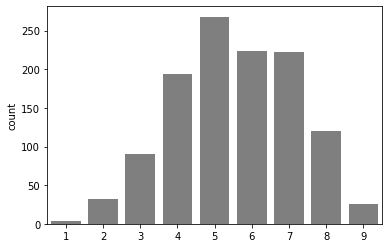

In [42]:
sns.countplot([len(v) for v in adj.values()], color='k', alpha=0.5)

In [43]:
model.state_dict()['lt.weight'][0]

tensor([-3.6574e-05,  6.8414e-06,  7.9119e-05,  2.7332e-05, -6.7489e-05,
        -6.8313e-05, -3.5115e-05, -7.4745e-05, -4.4043e-05,  3.3197e-05,
        -7.3887e-05,  5.5218e-05, -4.4537e-05,  7.0840e-05,  6.6370e-05,
         4.9938e-05, -5.6687e-05,  5.2993e-05,  4.4430e-05, -7.0127e-05])

In [146]:
model.lt.weight.data[0], model.lt.weight.data.shape

(tensor([-6.1642e-05, -3.2696e-05,  7.2417e-05, -2.0239e-05,  6.5140e-05,
         -8.1950e-05, -2.8843e-05,  8.3088e-05,  8.4223e-05,  3.5610e-05,
          9.3513e-05,  5.2176e-05,  4.1561e-05,  3.1950e-05,  9.9732e-05,
          9.8092e-05, -7.6160e-05,  2.6897e-05, -1.0316e-06, -3.1881e-05]),
 torch.Size([1180, 20]))

In [51]:
lt = model.w_avg if hasattr(model, 'w_avg') else model.lt.weight.data
d = lt.size(-1)
lt.shape, d, hasattr(model, 'w_avg')

(torch.Size([1180, 20]), 20, False)

In [152]:
lt.view(-1, d).shape

torch.Size([1180, 20])

In [153]:
ha = torch.randn((5,5,5))

In [157]:
ha.view(-1,5).shape

torch.Size([25, 5])

In [53]:
from torch.utils import data as torch_data

In [54]:
isinstance(data, torch_data.Dataset)

False

In [55]:
model.nobjects

1180

In [58]:
counts = th.zeros(model.nobjects, 1).to(device)
counts.shape

torch.Size([1180, 1])

In [61]:
hasattr(data, 'avg_queue_size'), hasattr(opt, 'asgd')

(False, False)

In [64]:
loader = data
loader_iter = loader

In [66]:
for i_batch, (inputs, targets) in enumerate(loader_iter):
    inputs = inputs.to(device)
    targets = targets.to(device)
    break

In [68]:
inputs.shape, targets.shape

(torch.Size([10, 52]), torch.Size([10]))

In [71]:
inputs.shape

torch.Size([10, 52])

In [145]:
e = model.lt(inputs)
e.shape

torch.Size([10, 52, 20])

In [90]:
f = model.manifold.normalize(e)

In [146]:
e[0,0,:], f[0,0,:]

(tensor([-8.9042e-05, -8.9023e-05,  3.9739e-05,  4.2959e-05,  5.6381e-05,
          9.1030e-05, -3.7944e-05, -2.4798e-06, -6.7622e-05,  1.1056e-05,
         -1.4679e-05,  6.0555e-05,  1.1933e-07,  3.4342e-05, -3.8167e-05,
          7.9373e-05,  3.3009e-05, -5.0486e-06, -2.9278e-05, -5.5729e-05],
        grad_fn=<SliceBackward>),
 tensor([-8.9042e-05, -8.9023e-05,  3.9739e-05,  4.2959e-05,  5.6381e-05,
          9.1030e-05, -3.7944e-05, -2.4798e-06, -6.7622e-05,  1.1056e-05,
         -1.4679e-05,  6.0555e-05,  1.1933e-07,  3.4342e-05, -3.8167e-05,
          7.9373e-05,  3.3009e-05, -5.0486e-06, -2.9278e-05, -5.5729e-05],
        grad_fn=<SliceBackward>))

In [174]:
torch.all(e == f)

tensor(1, dtype=torch.uint8)

In [91]:
f.shape

torch.Size([10, 52, 20])

In [176]:
with th.no_grad():
    e = model.manifold.normalize(e)

In [179]:
e.narrow(1, 1, e.size(1) - 1).shape

torch.Size([10, 51, 20])

In [181]:
e.narrow(1, 0, 1).shape

torch.Size([10, 1, 20])

In [185]:
e[0][0]

tensor([-8.9042e-05, -8.9023e-05,  3.9739e-05,  4.2959e-05,  5.6381e-05,
         9.1030e-05, -3.7944e-05, -2.4798e-06, -6.7622e-05,  1.1056e-05,
        -1.4679e-05,  6.0555e-05,  1.1933e-07,  3.4342e-05, -3.8167e-05,
         7.9373e-05,  3.3009e-05, -5.0486e-06, -2.9278e-05, -5.5729e-05],
       grad_fn=<SelectBackward>)

In [182]:
e.narrow(1, 0, 1)[0]

tensor([[-8.9042e-05, -8.9023e-05,  3.9739e-05,  4.2959e-05,  5.6381e-05,
          9.1030e-05, -3.7944e-05, -2.4798e-06, -6.7622e-05,  1.1056e-05,
         -1.4679e-05,  6.0555e-05,  1.1933e-07,  3.4342e-05, -3.8167e-05,
          7.9373e-05,  3.3009e-05, -5.0486e-06, -2.9278e-05, -5.5729e-05]],
       grad_fn=<SelectBackward>)

In [187]:
o = e.narrow(1, 1, e.size(1) - 1)
s = e.narrow(1, 0, 1).expand_as(o)

In [197]:
s.shape

torch.Size([10, 51, 20])

In [198]:
s[0][:2][:5]

tensor([[-8.9042e-05, -8.9023e-05,  3.9739e-05,  4.2959e-05,  5.6381e-05,
          9.1030e-05, -3.7944e-05, -2.4798e-06, -6.7622e-05,  1.1056e-05,
         -1.4679e-05,  6.0555e-05,  1.1933e-07,  3.4342e-05, -3.8167e-05,
          7.9373e-05,  3.3009e-05, -5.0486e-06, -2.9278e-05, -5.5729e-05],
        [-8.9042e-05, -8.9023e-05,  3.9739e-05,  4.2959e-05,  5.6381e-05,
          9.1030e-05, -3.7944e-05, -2.4798e-06, -6.7622e-05,  1.1056e-05,
         -1.4679e-05,  6.0555e-05,  1.1933e-07,  3.4342e-05, -3.8167e-05,
          7.9373e-05,  3.3009e-05, -5.0486e-06, -2.9278e-05, -5.5729e-05]],
       grad_fn=<SliceBackward>)

In [208]:
dists = model.dist(s, o).squeeze(-1)

In [211]:
dists[0][1]

tensor(1.0085e-07, grad_fn=<SelectBackward>)

In [209]:
dists.shape

torch.Size([10, 51])

In [72]:
preds = model(inputs)

In [86]:
preds.shape

torch.Size([10, 51])

In [75]:
preds[0]

tensor([-1.0990e-07, -1.0085e-07, -1.2913e-07, -1.7251e-07, -1.0660e-07,
        -9.1251e-08, -8.0313e-08, -8.4797e-08, -8.2516e-08, -1.4333e-07,
        -1.1134e-07, -1.3206e-07, -1.4894e-07, -1.1647e-07, -1.3862e-07,
        -1.4654e-07, -1.5819e-07, -1.3007e-07, -1.7866e-07, -1.4782e-07,
        -1.0574e-07, -1.3597e-07, -1.4050e-07, -1.1529e-07, -1.2968e-07,
        -1.3894e-07, -1.9336e-07, -1.2252e-07, -1.4715e-07, -1.7191e-07,
        -1.5287e-07, -1.3140e-07, -1.0668e-07, -1.7442e-07, -1.0453e-07,
        -9.9535e-08, -1.2608e-07, -1.7767e-07, -9.9174e-08, -1.3276e-07,
        -1.1570e-07, -1.4056e-07, -1.4479e-07, -1.0988e-07, -4.3901e-08,
        -1.2366e-07, -1.1937e-07, -1.4813e-07, -1.1280e-07, -9.8269e-08,
        -1.3287e-07], grad_fn=<SelectBackward>)

In [78]:
model.lossfn

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')>

In [87]:
model.forward

<bound method Embedding.forward of Embedding(
  (lt): Embedding(1180, 20, sparse=True)
)>

In [106]:
x = torch.randn(10, 5, 20)
d = x.size(-1)
x.view(-1, d).sum(0).shape

torch.Size([20])

In [161]:
x = torch.ones(4, 3)
x[1] = torch.DoubleTensor([2,3,4])
x[2] = torch.DoubleTensor([4,5,6])
x[3] = torch.DoubleTensor([7,8,9])
x.shape, x

(torch.Size([4, 3]), tensor([[1., 1., 1.],
         [2., 3., 4.],
         [4., 5., 6.],
         [7., 8., 9.]]))

In [162]:
x_norm = torch.renorm(x, 2, 0, 3)

In [165]:
torch.norm(x, 2, 1)

tensor([ 1.7321,  5.3852,  8.7750, 13.9284])

In [166]:
(x[:,1]*x[:,1]).sum(-1).sqrt()

tensor(9.9499)

In [171]:
torch.norm(x_norm, 2, 1)

tensor([1.7321, 3.0000, 3.0000, 3.0000])

In [168]:
x_norm

tensor([[1.0000, 1.0000, 1.0000],
        [1.1142, 1.6713, 2.2283],
        [1.3675, 1.7094, 2.0513],
        [1.5077, 1.7231, 1.9385]])

In [158]:
(x_norm[:,2]*x_norm[:,2]).sum(-1).sqrt()

tensor(3.0000)

In [170]:
(x_norm[0,:]*x_norm[0:]).sum(-1).sqrt()

tensor([1.7321, 2.2391, 2.2646, 2.2736])

In [173]:
'''
Code normalizes along the row: each of the embedding dimension ... 
Therefore the p-norm for each vector < max norm
'''

'\nCode normalizes along the row: each of the embedding dimension ... \nTherefore the p-norm for each vector < max norm\n'